<a href="https://colab.research.google.com/github/dianabohorquez/spotify/blob/main/TimeSeries_ARIMA_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

La presente notebook contiene todo el desarrollo nesario para el primer TP de la materia **Análisis de Series Temporales** de la maestría en ciencia de datos de la Universidad Austral (cohorte 2020-2021).

En la [notebook A01_EDA](https://github.com/dianabohorquez/spotify/blob/main/A01_EDA_Spotify.ipynb) se hizo una breve exploración del dataset de Spotify. Se encontraron como variables de interés `energy` y `valence` toda vez que tienen un comportamiento no estacionario en todo la ventana de tiempo disponible en el dataset y su definición pareceriera interesante de por sí. En este data set se recuenta las observaciones destacadas de la notebook A01_EDA.

El objetivo de esta notebook es hacer pronóstico de estas variables aplicando los conceptos vistos en clase (o tal vez mejor decir aquí siguiendo la metodología de JB):

- Uno
- Dos
- Tres


---

En unos primeros párrafos colocar porque está bueno el análisis de series temporales.
En una segunda parte colocar que se va a analizar y porqué spotify. Cuál es el interés Aquí resuelvo “Buscar dos series de tiempo y exponer la problemática de interés analítico (y bla bla bla)”.
En un tercer párrafo cómo está organizado el TP, por ejemplo, de cómo son los capítulos organizados, cómo están vinculados con cada pregunta.
También aquí colocar las fuentes.
Acá la consigna, tal vez parafraseada


### Preparación del entorno

In [1]:
# manipulación de data frames y EDA
import pandas as pd
import numpy as np
from datetime import timedelta                                 # diferencia de dos fechas

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

# paquetes estadísticos - modelado de series temporales
import statsmodels.api as sm                                   # modelos estadísticos
#!pip install pmdarima
import pmdarima as pm                                          # modelado automático SARIMA
from statsmodels.tsa.arima_model import ARIMA                  # modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX         # modelo SARIMAX
from pylab import rcParams                                     # descomposicion de series temporales
from statsmodels.tsa.stattools import adfuller, kpss           # test Dickey-Fuller y KPSS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # plot the (P)ACF

import warnings
warnings.filterwarnings("ignore")

In [2]:
# accessing to google
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)   #to attempt to forcibly remount  force_remount

# setting working directory
import os
os.chdir("/content/gdrive/My Drive/Data Scientist/spotify/datasets/")

Mounted at /content/gdrive


# Planteamiento del Problema

Si se refiere a datos de YouTube, Netflix o Spotify institivamente cualquiera puede responder qué producción musical o audivisual es un hit: si lleva tiempo siendo muy vista o escuchada o si rompió algún record de visitas estamos ante un producto *pop*. Para el caso de Spotify, en su [página de desarrollador](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features) ellos mencionan por ejemplo, que la `popularity` de una canción es de hecho un valor calculado por un algoritmo basado, en mayor medida, en la cantidad de reproducciones que tiene una canción. Pero, ¿cómo se puede explicar esta popularidad?

Spotify ha estructurado información no estructurada para *explicar* en términos de datos la música, definiendo variables como `loudness` (volumen general de una pista en dB), `liveness` (probabilida que el track se realizó en vivo) o `acousticness` (medida de confianza de si la pista es acústica o no). Una breve exploración de estas y otras variables se encuentran en la la [notebook A01_EDA](https://github.com/dianabohorquez/spotify/blob/main/A01_EDA_Spotify.ipynb).

De acuerdo a esa exploración, a la oportunidad de buscar analizar series de comportamiento no estacionario y a la definición que Spotify da a sus variables, se preseleccionaron para este trabajo práctico `energy` y `valence`.

- **release_date** contiene la fecha de lanzamiento, la mayoría con formato yyyy-mm-dd.
- **energy** con un rango de 0.0 a 1.0 representa una medida perceptiva de intensidad y actividad. Por lo general, las pistas enérgicas se sienten rápidas y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características de percepción que contribuyen a este atributo incluyen rango dinámico, volumen percibido, timbre, frecuencia de inicio y entropía general.
- **valence**: con un rango de 0.0 a 1.0 `valence` describe la positividad musical que transmite una pista. Las pistas con valencia alta suenan más positivas (por ejemplo, feliz, alegre, eufórico), mientras que las pistas con valencia baja suenan más negativas (para el caso de adjetivos como triste, deprimido, enojado).

Varios datasets de Spotify están disponible en [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks). Particularmente para este trabajo práctico se utilizará  `data_o.csv`, renombrado `spotify_o.csv.zip`

Es interés para este trabajo práctico pronosticar el comportamiento futuro de estas tres variables haciendo uso de análisis de series temporales.

In [5]:
# importación de datos
spotify = pd.read_csv('spotify_o.csv.zip', usecols=['release_date', 'energy', 'valence'])

# Habilitando el dataframe para trabajarlo como una serie temporal
spotify.release_date = pd.to_datetime(spotify.release_date)
spotify.set_index('release_date', inplace=True)

# Análisis Exploratorio de los Datos y Preprocesamiento

En general este data set parece limpio. No tiene valores ausentes, aparentemente sus datos son consistentes presentan muy pocos outliers y su distribución tiende a estar normalizada. Otros datos relevantes del data set son:

- La base de datos consta de 170.653 registros y 2 variables.
- No todas las canciones tienen la fecha de lanzamiento completo (algunas solo el año).
- Las observaciones van del año 1921 a 2020.
- No hay valores faltantes o nulos
- La naturaleza de los datos parece estandarizada.

In [6]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 170653 entries, 1921-01-01 to 2020-10-16
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   valence  170653 non-null  float64
 1   energy   170653 non-null  float64
dtypes: float64(2)
memory usage: 3.9 MB


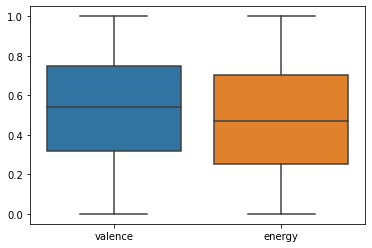

In [ ]:
sns.boxplot(data=spotify);

**Tanto la variable `valence` como `energy` podría pensarse con variables con distribuciones uniformes.**

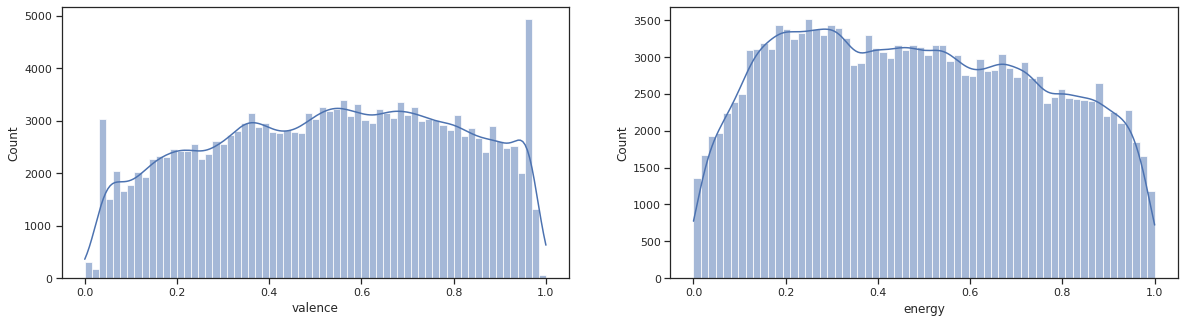

In [7]:
sns.set_theme(style="ticks")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.histplot(data=spotify, x="valence", kde=True, ax=axs[0]);
sns.histplot(data=spotify, x="energy", kde=True, ax=axs[1]);

**Al graficar en un histograma (haciendo un corte entre 1975 y 1977, y 2006 y 2008) la cantidad de canciones que se lanzaron mensualmente, hay un interesante patrón que muestra como en enero se hacían en promedio nueve veces más lanzamientos que en los otros meses.**

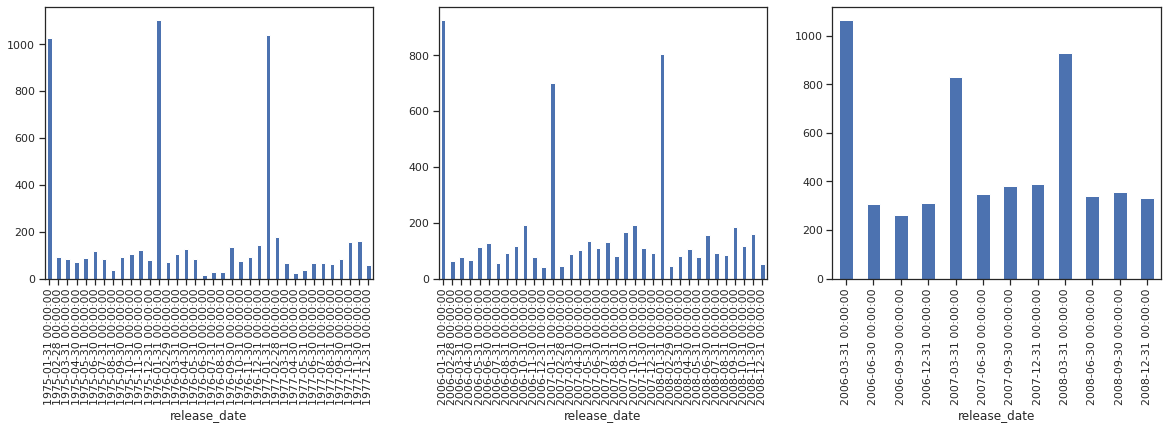

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

spotify['energy'].groupby(pd.Grouper(freq="M")).count().loc['1975':'1977'].plot(kind="bar", ax=axs[0]);
spotify['energy'].groupby(pd.Grouper(freq="M")).count().loc['2006':'2008'].plot(kind="bar", ax=axs[1]);
spotify['energy'].groupby(pd.Grouper(freq="Q")).count().loc['2006':'2008'].plot(kind="bar", ax=axs[2]);

**Por último y con el objeto de decidir la ventana temporal y la frecuencia en la que se trabajarán las series temporales se grafica cada variable promediando su valor anual.**

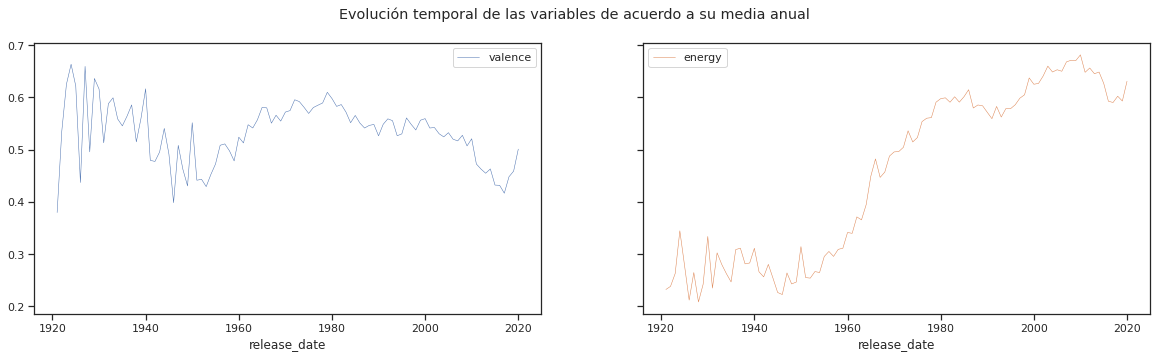

In [9]:
spotify.groupby(spotify.index.year).mean().plot(subplots=True
                                                , linewidth=0.5, layout=(1,2), figsize=(20, 5)
                                                , sharex=False, sharey=True
                                                , title = 'Evolución temporal de las variables de acuerdo a su media anual');

En resumen, algunas de las características observadas en este apartado exploratorio son:

- Con periodicidad anual las señales se suavisan siendo menos ruidosas.
- Con el pasar de los años los valores tienen menos variabilidad.
- Cerca y después del año 1960 la información parece menos errática.
- Visualmente se puede decir que ningunas de las dos series es estacionaria.
- Hay una aparente estacionalidad presente anualmente en los meses de enero. Esta variación periódica podría también representarse trimestralmente.

Considerando todas estas observaciones se define como dataset de interés los datos a partir de 1960 y agrupados trimestralmente.

In [10]:
# Eliminado los datos menores a 1960 (inclusive) y agrupándolos según su promedio trimestral
spotify = spotify.groupby(pd.Grouper(freq="Q")).mean()
spotify = spotify.iloc[160:,]

# Marco Teórico

El objetivo de este TP es pronosticar el comportamiento de tres variables que definen características del audio de  algunas de las canciones disponibles en Spotify.

## Propiedades de las series temporales

***Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. Exponer los conceptos relacionados con la estacionariedad de la serie. Utilizar como criterio un test de raíces unitarias que considere pertinente.***

Visualmente ninguna de las series parece estacionaria, ya que por lo pronto se evidencian en ellas cierta tendencia,  en `valence` por ejemplo, una negativa y en `energy` una positiva.

Para testear la hipótesis de estacionariedad se correrán test de raíces unitarias, pero antes de esto se repasarán someremente las propiedades que describen una serie temporal.

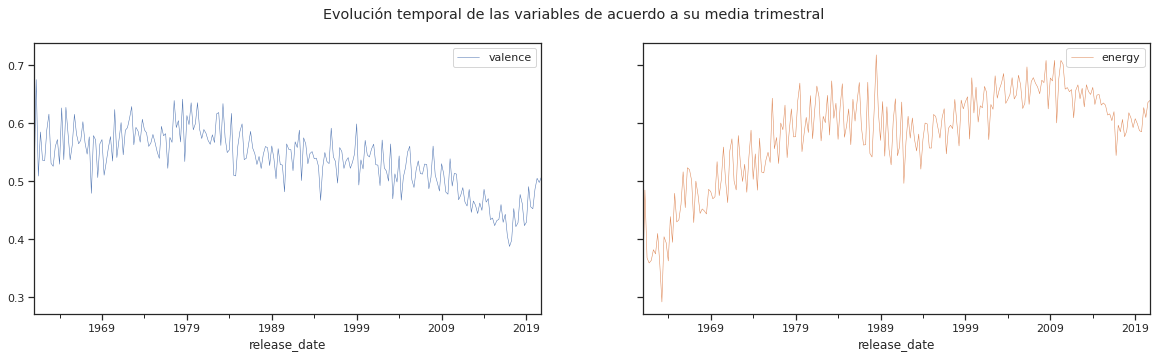

In [11]:
spotify.plot(subplots=True
             , linewidth=0.5, layout=(1, 2), figsize=(20, 5)
             , sharex=False, sharey=True
             , title = 'Evolución temporal de las variables de acuerdo a su media trimestral');

Una **serie temporal** es la representación de una variable y su evolución en el tiempo a intervalos regulares. Si esta evolución es estadísticamente estable en el tiempo, particularmente con respecto a la media y la varianza, se dice que la **serie es estacionaria**. **{99-9 Practical Time Series Analysis_ Prediction with Statistics and Machine Learning-O’Reilly_Nielsen (2019), pagPDF82}**

Visualmente se puede tener una intuición acerca de la estacionariedad o no de una variable, por ejemplo, si el valor medio de la variable crece o decrece en intervalos de tiempo, si la amplitud entre los valores máximos y mínimos varían en el tiempo, o si parece existir un patrón que se repite a lo largo de la serie temporal se está ante una serie no estacionaria.

Matemáticamente hablando un proceso es estacionario si todos los posibles lags, $k$, con distribución de probabilidad $y_{t}, y_{t+1}, ..., y_{t+k}$ no dependen del tiempo, $t$.

Un test de hipótesis para determinar si una serie es o no estacionaria  es el **test Dickey-Fuller Aumentado (ADF)**, el cual tiene como hipótesis nula que hay una raiz unitaria en la serie **{pie de página: Una serie temporal lineal es no estacionaria si existe una raíz unitaria, aunque la ausencia de una raíz unitaria no demuestra la estacionariedad}** concentrándose particularmente en si la media de la serie cambia con el tiempo.

El marco para el test de Dickey-Fuller plantea lo siguiente:

$\Delta y_{t} =  y_{t} - y_{t-1} = \alpha + \beta P_{t-1} + \epsilon_{t}$

Siendo las hipótesis:

- $H_{0}: \beta = 1$ ( es un random walk) ➡ significa que la serie tiene una raiz unitaria, lo que significa que la serie no es estacionaria.
- $H_{1}: \beta < 1$ (no es random walk) ➡ implica que la serie temporal podría ser estacionaria.

Hablando de la implementación en Python, el elemento cero de la función [adfuller](hps://www.statsmodels.org/dev/generated/statsmodels.tsa.staools.adfuller.html) indica el test estadístico (entre más negativo es más probable la estacionariedad) y el primer elemento es el p-value (valores menores a 0.05 rechazan la hipótesis nula y se asume que la serie debe ser estacionaria. **{Se rechaza no estacionariedad}**).



Se mencionó que el test ADF mostraba particular interés en la evolución de la media, en contrastre y en relación a la varianza,  esta se maneja más con trasnformaciones que con un test formal, siendo usuales las siguientes:

**Haciendo una serie temporal estacionaria**

- Transformación por diferencia: $\Delta y_{t} = y_{t}-y_{t-1}$ → `df.diff()`. Típicamente usado para remover tendencia de una serie.
- Las transformaciones por el logaritmo → `np.log(df)` y la raíz cuadrada → `np.sqrt(df)`, son particularmente útiles para el caso de cambios en la varianza en el tiempo.
- Tomando el cambio proporcional → `df.shift(1)/df`

Hasta ahora se ha hablado de las características de una serie estacionaria, del test comunmente usado para rechazar o no la hipótesis de estacionariedad de una variable o de las transformaciones necesarias para transformarla en estacionaria. Es el turno, entonces, de hablar de las características que hacen a una serie **no estacionaria**: **{99-89 Forecasting_Principles and Practice-Otexts_Hyndman (2018) la del muchacho en el tablero PDF pag32}**

- En una serie temporal la **tendencia** indica que sobre un largo periodo de tiempo la serie decrece o crece, sin que implique que estos cambios sean lineales.
- La **estacionalidad** ocurre por razones de estación, puede ser un aumento de suscripciones en el gimnasio a inicios de años o de mes, o mayor venta de helados en los meses de verano. En este caso la frecuencia es fija o conocida en la serie de tiempo
- Similar a la estacionalidad una serie es **cíclica** si se observan patrones que se repiten a lo largo del tiempo, pero se diferencia en que la frecuencia no es fija.

Identificar si la serie tiene uno o varios de estos compartamientos es importante a la hora de elegir cómo modelarlas y los métodos que pueden capturar cada una de estas señales.

Por último, se destaca la importancia de contar con datos estacionarios o de hacer las transformaciones necesarias para lograrlo, toda vez que gran cantidad de modelos de series temporales trabajan sobre procesos estacionarios. Esto se explica desde el hecho que al buscar en un modelo estimar la media de una serie temporal con una media o varianza variables, el sesgo y el error también variarán con el tiempo lo que hará indefectiblemente que los resultados del modelo sean cuestionables.

### Descomposición y test de estacionariedad ➡ variable Valence 😄

Al analizar una a una las componenetes de la descomposición de la variable `valence` se observa:
- Una ligera **tendencia** positiva hasta el año 1980 y notablemente negativa de 1980 a 2008 aproximadamente. Esta tendencia puede ser capturada por el modelo incluyendo una componente autorregresiva AR.
- Parace haber un claro patrón **estacional** en la serie fluctuando entre los valores 0.0075 y -0.0075. Intuitivamente se puede pensar que esto está presente en los lanzamientos anuales (cada enero o primer trimestre) que son claramente superiores a los demás meses del año. Esta señal puede ser modelada trabajando con un modelo SARIMA.
- No sé aprecia un patrón en los residuos.

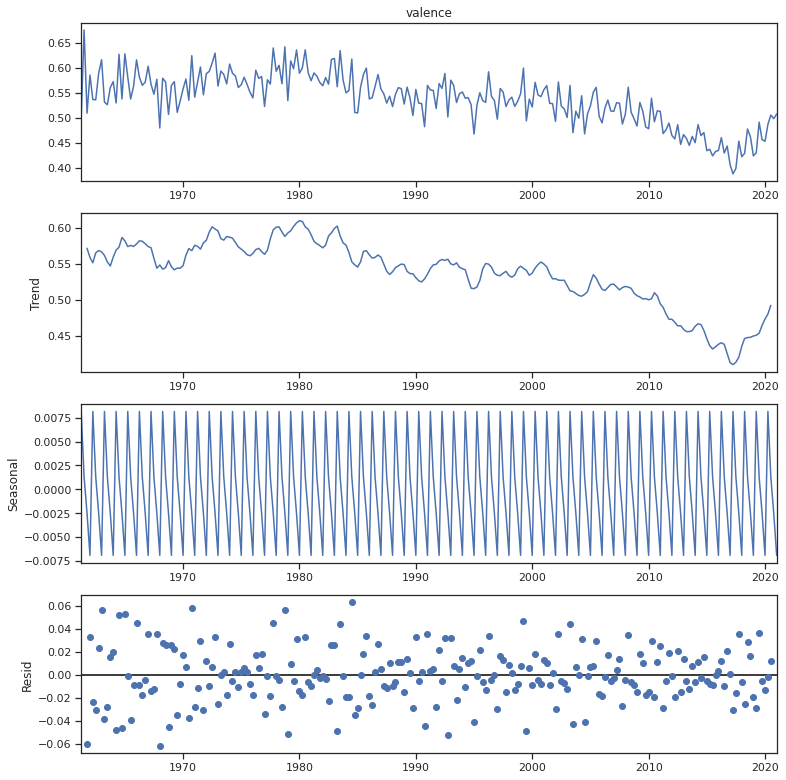

In [12]:
# Descomposicion de la serie temporal Valence
rcParams['figure.figsize'] = 11, 11
decomposeValence = sm.tsa.seasonal_decompose(spotify['valence'])
fig = decomposeValence.plot();

Para comprobar lo observado gráficamente se corre el test ADF obteniendo como *p-value 0.3980* con lo cual no se puede rechazar H0 de tal forma que no se puede asumir estacionariedad en la serie.

In [13]:
v_adfuller = adfuller(spotify['valence'])
print('p-value del test adfuller para valence: ', v_adfuller[1])

p-value del test adfuller para valence:  0.39803824750457206


Este resultado implica que la serie debe ser transformada, inicialmente tomando la primera diferencia para hacerla estacionaria. Después de esta transformación y analizando los gráficos de función de autocorrelación y autocorrelación parcial se tendrá una idea del modelo (AR, MA, ARMA o ARIMA) y su orden.

In [14]:
# Aplicando diferencia al dataset
spotifyDiff = spotify.diff().dropna()

In [15]:
sav_adfuller = adfuller(spotifyDiff['valence'])
print('p-value test adfuller quarter valence: ', sav_adfuller[1], '-> entonces no rechazamos H0, por lo tanto la serie es un random walk')

p-value test adfuller quarter valence:  2.9421281845410765e-30 -> entonces no rechazamos H0, por lo tanto la serie es un random walk


### Descomposición y test de estacionariedad ➡ variable Energía ⚡ 

Para el caso de la variable `energy`  se analiza lo siguiente de las componentes de la serie:

- Hay una clara tendencia positiva al pasar los años.
- Igual que en `valence` parece claro la existencia de estacionalidad en las series.
- Los residuos también parecen aleatorios.

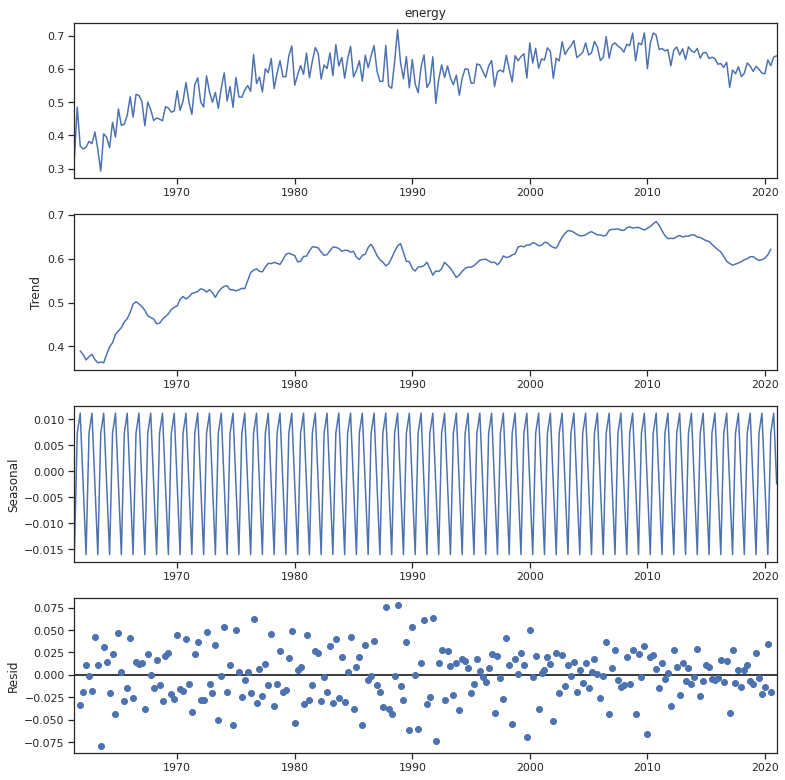

In [16]:
# Descomposicion de la serie temporal Energy
rcParams['figure.figsize'] = 11, 11
decomposeValence = sm.tsa.seasonal_decompose(spotify['energy'])
fig = decomposeValence.plot();

Para el caso de `energy` el test ADF arroja un *p-value de 0.01715* rechazando H0, por lo tanto la serie no es un random walk, entonces la serie es estacionaria.

In [17]:
e_adfuller = adfuller(spotify['energy'])
print('p-value del test adfuller para energy: ', e_adfuller[1])

p-value del test adfuller para energy:  0.017150791572558406


Este resulado es llamativo a la vista del análisis de descomposición de la serie. Algunas de las razones que pueden estar detrás de este resultado es que el test tiene poco poder en distinguir entre raíces unitarias y raíces unitarias cercanas o los datos puedan ser pocos para el test **{el de la oveja página 85PDF}**.

Una alternativa a este test es el **KPSS Test** que para el caso de la serie `energy` el *p-value es de 0.01*.

In [18]:
kpsstest = kpss(spotify['energy'], regression="c", nlags="auto")
print('p-value del test kpss para energy: ', kpsstest[1])

p-value del test kpss para energy:  0.01


Estos dos resultados, tanto el de ADF y KPSS, rechazan la hipótesis nula sobre la alternativa, por lo tanto la serie es estacionaria.

Siempre es mejor aplicar las dos pruebas para asegurarse de que la serie es realmente estacionaria[PARA LA BIBLIOGRAFIA](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html). Los posibles resultados de la aplicación de estas pruebas de estacionariedad son los siguientes:

- Si ambas pruebas concluyen que la serie es o no es estacionaria entonces, la serie es o no es estacionaria, respectivamente.
- Si el KPSS indica estacionariedad y el ADF indica no estacionariedad, entonces la serie es estacionaria por tendencia. En este caso es necesario eliminar la tendencia para que la serie sea estrictamente estacionaria.
- Si el KPSS indica no estacionariedad y el ADF indica estacionariedad, entonces la serie es estacionaria por diferencia. Se debe utilizar la diferenciación para hacer que la serie sea estacionaria.

A partir de estos resultados y graficando las funciones de autocorrelación y autocorrelación parcial sin diferenciar la serie se podrá tener una idea del orden del modelo.

## 2. Función de Autocorrelación

*Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría.*

La autocorrelación es un valor numérico (rango -1 a 1) que indica cuánto una serie temporal está correlacionada consigo misma separada por un específico número de periodos, denominados lags. **La función de autocorrelación (ACF)** permite observar esta correlación considerando diferentes retardos. Algunos de sus usos son:

- Cualquier autocorrelación (estadísticamente) significante implica que la serie puede ser pronosticada considerando su pasado.
- Se pueden observar que lags específicos contribuyen al modelo.
- Se observan también comportamientos estacionales
- Ayudan a seleccionar las órdenes del modelo que mejor se ajustará a los datos.
    - Para el caso de los modelos MA se debe observar la función de autocorrelación, mientras que,
    - La función de autocorrelación parcial ayudan a identificar el órden para el modelo AR

**acá unas ecuaciones de los retardos y el percio de hoy para ACF. en el de pcaf solo veo los compones directos eliminando lis lags intermeduos. Ver si eso lo tengo en las otras nb.**

**Descripción matemática del modelo AR(1)**

$R_{t} = \mu + \phi R_{t-1} + \epsilon_{t}$

- Este es un modelo AR(1) porque solo está presente un lag
- $\phi$ es el AR parameter (se puede entender como una fración $\phi$ del valor de ayer)
    - $\phi$ Negativo: Mean reversion (habíamos dicho que es como un serrucho, porque si multiplico + - da negativo, entonces la siguiente multiplicación es - - entonces da positivo)
    - $\phi$ Positivo: Momentum (como empienza en positivo, el siguiente es positivo, and so on, entonces es más como una montaña)
    - $\phi = 1$: Random walk
    - $\phi = 0$: White noise
- Para estacionarierdad $-1<\phi<1$

**Choosing the Right Model**

**Identificando el orden de un AR Model** usando:
- Partial Autocorrelation Function, o
- Information criteria (adjusts goodness-of-fit for number of parameters) ... Muchos parámetros en el modelo pueden overfitearlo, entonces estos IC me ayudan a ver esa bondad de ajuste considerando los parámetros incluidos en el modelo y penalizándo el modelo basados en el número de parámetros usados.
    - AIC (Akaike Information Criterion)
    - BIC (Bayesina Information Criterion)
        - Choose p {AR(p)}with the lowest BIC

**Partial Autocorrelation Function (PACF)**

$R_{t}=\phi_{0,1}+{\color{Red} \phi _{1,1}}R_{t-1}+\epsilon_{1t}$

$R_{t} = \phi_{0,2} + \phi_{1,2} R_{t-1} +{\color{Red} \phi _{2,2}}R_{t-2}+ \epsilon_{2t}$

$R_{t} = \phi_{0,3} + \phi_{1,3} R_{t-1} + \phi_{2,3} R_{t-2}+{\color{Red} \phi _{3,3}}R_{t-3}+ \epsilon_{3t}$

$R_{t} = ...$

Los coeficientes ${\color{Red} \phi _{x,x}}$ representan los valores de las funciones de autocorrelaciones parciales para diferentes lags. Por ejemplo ${\color{Red} \phi _{3,3}}$ es el valor de lag-3 del PACF y representa qué tan significante es para el modelo la suma de un tercer lag cuando ya se tienen dos lags.


**Descripción matemática del modelo MA(1)**

$R_{t} = \mu + \epsilon_{t} + \theta \epsilon_{t-1}$

> Este era el de AR(1) $R_{t} = \mu + \phi R_{t-1} + \epsilon_{t}$

- El parámetro MA es $\theta$. También puede leerse como una fracción $\theta$ del ruido de un periodo anterior
- El modelo es estacionario para todos los valores de $\theta$

**Interpretación del MA(1) parameter**
- $\theta$ Negativo: un periodo de reversión a la media
- $\theta$ Positivo: un periodo de momentum
- $\theta = 0$: es un white noise
- NOTA: un periodo de autocorrelación es $\frac{\theta}{1+\theta^2}$, no $\theta$

### Análisis de Autocorrelación ➡ variable Energía ⚡

La gráfica de autocorrelación de `energy` muestra que sus observaciones sucesivas están correlacionadas positivamente, pero al no decrecer rápidamente hacia cero sugiere que el proceso tiene efectivamente una tendencia con lo cual no sería estacionario [BIBLIO PAG 13 PDF](https://addi.ehu.es/bitstream/handle/10810/12492/04-09gon.pdf) ni el gráfico informativo.

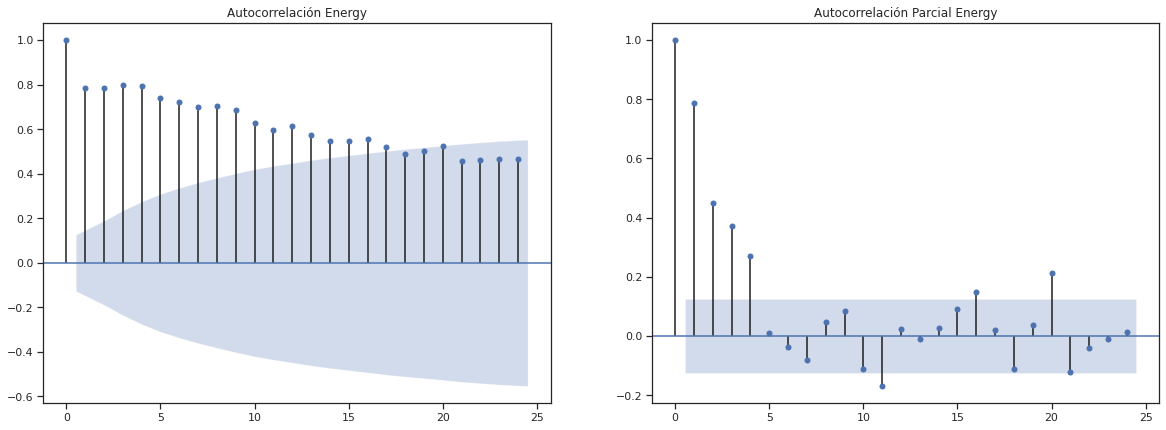

In [19]:
# Gráfica ACF y PACF de energy
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(spotify['energy'], ax=axes[0], title='Autocorrelación Energy');
plot_pacf(spotify['energy'], ax=axes[1], title='Autocorrelación Parcial Energy');

Al diferenciar la variable parece corregirse la no estacionariedad sugerida en el FAC inicial y que un modelo funcional sería el MA(1). Para el caso de la FACP se estaría ante un modelo AR(4). En ninguna de las dos gráficas se evidencia estacionalidad de la serie.

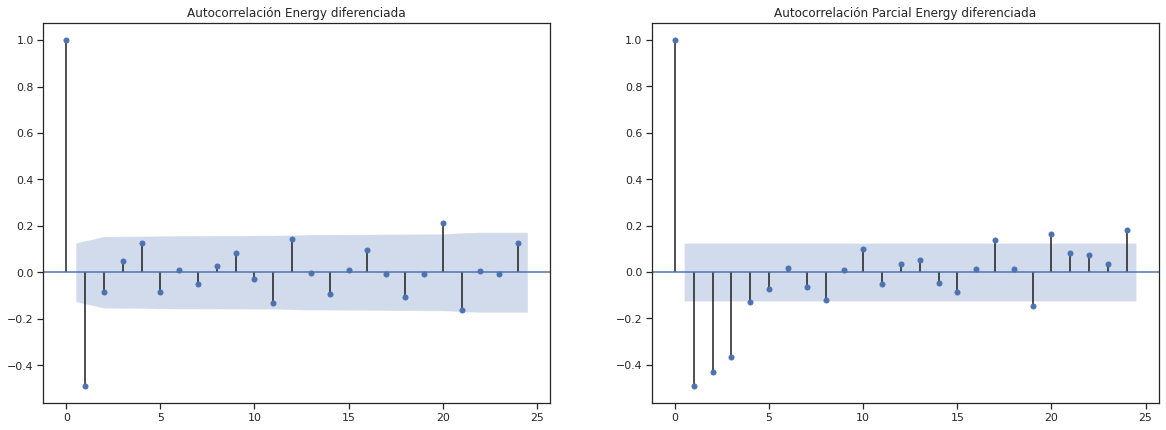

In [20]:
# Gráfica ACF y PACF de energy
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(spotifyDiff['energy'], ax=axes[0], title='Autocorrelación Energy diferenciada');
plot_pacf(spotifyDiff['energy'], ax=axes[1], title='Autocorrelación Parcial Energy diferenciada');

### Análisis de Autocorrelación  ➡ variable Valence 😄

Para el caso de `valence` la función de autocorrelación sugiere un modelo MA(1) y la de autocorrelación parcial uno AR(3). En este análisis no se identifican componentes de estacionalidad.

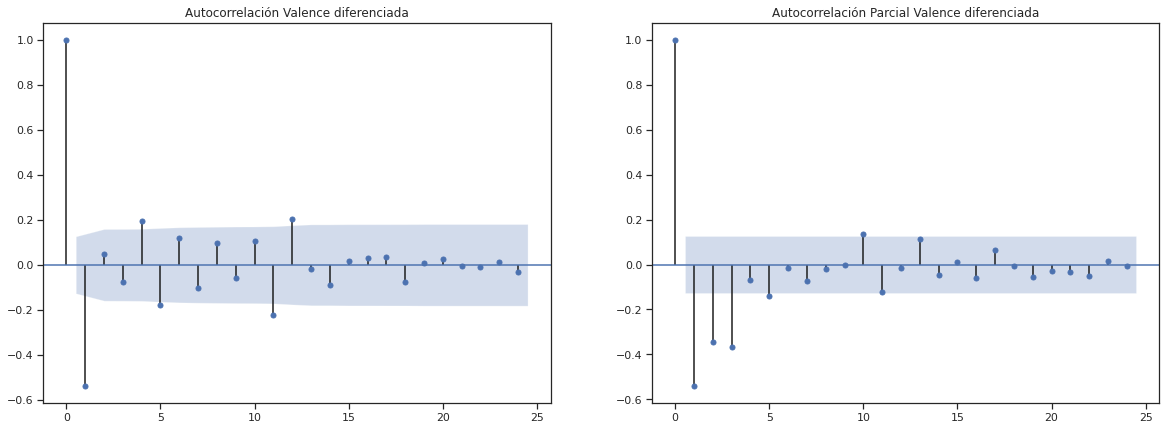

In [21]:
# Gráfica ACF y PACF de valence con la serie original y diferenciada
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(spotifyDiff['valence'], ax=axes[0], title='Autocorrelación Valence diferenciada');
plot_pacf(spotifyDiff['valence'], ax=axes[1], title='Autocorrelación Parcial Valence diferenciada');

## Modelado ➡ variable Energía ⚡


*En este apartado se realizará una estimación de las series temporales con distintos órdenes para un modelo ARIMA, dado que no se encontró evidencia en de estacionalidad en la función de autocorrelación para plantear modelo SARIMA. Con el objeto de analizar el desempeño del modelo las series serán separadas en entrenamiento y test.*

In [22]:
# Split los datos en entrenamiento y test
spotify_train = spotify.loc[:'2002']
spotify_test = spotify.loc['2003':]

# Index de las fechas de test
dates_test = spotify_test.index

### Estimando el orden del modelo

*Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos (S)ARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información y analizar significatividad individual y global de los parámetros del modelo).*

Considerando el análisis hecho sobre las funciones de autocorrelación se iterará sobre modelos hasta de órdenes AR(4) y MA(10) para la variable `energy`; a pesar que los test de no estacionaridad indicaron que esta serie es estacionaria, la función de autocorrelación indicaba no estacionaridad razón por la cual también se iterará por un orden I(1).

In [ ]:
# Estimando el mejor modelo ARIMA para energy
order_energy =[]
# Loop sobre orden de AR
for p in range(5):
    # Loop sobre orden de Integración
    for d in range(2):
        # Loop sobre orden de MA
        for q in range (11):
            try:
                # Ajuste del modelo modelo
                model = SARIMAX(spotify_train['energy'], order=(p,d,q))
                results = model.fit()
                # impresión del orden del modelo con valores AIC/BIC
                print(p, d, q, results.aic, results.bic)
                # Sumar orden y resultados a la lista
                order_energy.append((p, d, q, results.aic, results.bic))
            except:
                # Impresión de AIC y BIC como None cuando el modelo falla
                print(p, d, q, None, None)
 
# Creación de dataframe con los órdenes del modelo y los resultados de AIC/BIC
order_df_energy = pd.DataFrame(order_energy, columns=['p', 'd', 'q', 'aic', 'bic'])

### Selección del Modelo y Análisis de Diagnóstico

Según los Criterios de Información los mejores modelos podrían ser ARIMA(0,1,3), ARIMA(2,1,1) o (4,1,4). Interesante de este experimiento es el hecho que efectivamente la serie necesitaría diferenciarse para poder tener un mejor ajuste.

In [24]:
print(order_df_energy.sort_values('bic').head(5))

    p  d  q         aic         bic
14  0  1  3 -583.934052 -571.462077
56  2  1  1 -583.459311 -570.987336
13  0  1  2 -580.147312 -570.793331
12  0  1  1 -576.187976 -569.951989
35  1  1  2 -581.582647 -569.110672


In [25]:
print(order_df_energy.sort_values('aic').head(5))

     p  d  q         aic         bic
103  4  1  4 -584.393988 -556.332043
14   0  1  3 -583.934052 -571.462077
78   3  1  1 -583.548711 -567.958742
56   2  1  1 -583.459311 -570.987336
57   2  1  2 -583.078310 -567.488341


**Corriendo un `auto_arima` se sugiere también que un bueno modelo sería el ARIMA(2,1,1)**

In [26]:
e_autoarima = pm.auto_arima(spotify_train['energy'], seasonal=True)
e_autoarima

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

**Haciendo una comparación de estos tres modelos se tiene el siguiente resumen:**

| Modelo | AIC | BIC | Ljung-Box (L1) (Q) | Prob(Q) | Jarque-Bera (JB) | Prob(JB)|
| - | - | - | - | - | - | - |
| ARIMA(0,1,3) | -583.934 | -571.462 | 0.02 | 0.89 | 0.79 | 0.97 |
| ARIMA(2,1,1) | -583.459 | -570.987 | 0.19 | 0.66 | 0.72 | 0.70 |
| ARIMA(4,1,4) | -584.428 | -556.366 | 0.00 | 1.0 | 0.52 | 0.77 |

- Dado el valor de AIC del modelo ARIMA(0,1,3) se puede inferir que este es el mejor predictor.
- Dado el valor de BIC del modelo ARIMA(4,1,4) se puede inferir que este es el que mejor explica al modelo.
- Dado los valores de p-value de JB no se puede rechazar la hipótesis nula que los residuos están normalmente distribuidos.
- Para el caso de los p-value de Ljung-Box no se puede rechazar la hipótesis nula que los residuos estén correlacionados, por lo tanto no quedan señales sin capturar en el modelo.

Primando por un modelo parsimonioso se elige el modelo ARIMA(0,1,3) para la serie de `energy`.

$\hat{y}_{t} = -0.936_{\epsilon_{t-1}}+0.185_{\epsilon_{t-3}}$

In [28]:
# Modelo ARIMA para energy
arima_energy = SARIMAX(spotify_train['energy'], order=(0,1,3))
arima_energy_results = arima_energy.fit()
print(arima_energy_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                  168
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 295.967
Date:                Sat, 31 Jul 2021   AIC                           -583.934
Time:                        02:06:59   BIC                           -571.462
Sample:                    03-31-1961   HQIC                          -578.872
                         - 12-31-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9360      0.088    -10.605      0.000      -1.109      -0.763
ma.L2          0.0410      0.117      0.352      0.725      -0.188       0.270
ma.L3          0.1846      0.083      2.224      0.0

**Viendo visualmente los residuos se comprueba que efectivamente estos están normalmente distribuidos, no presentan patrón y no hay una correlación entre ellos.**

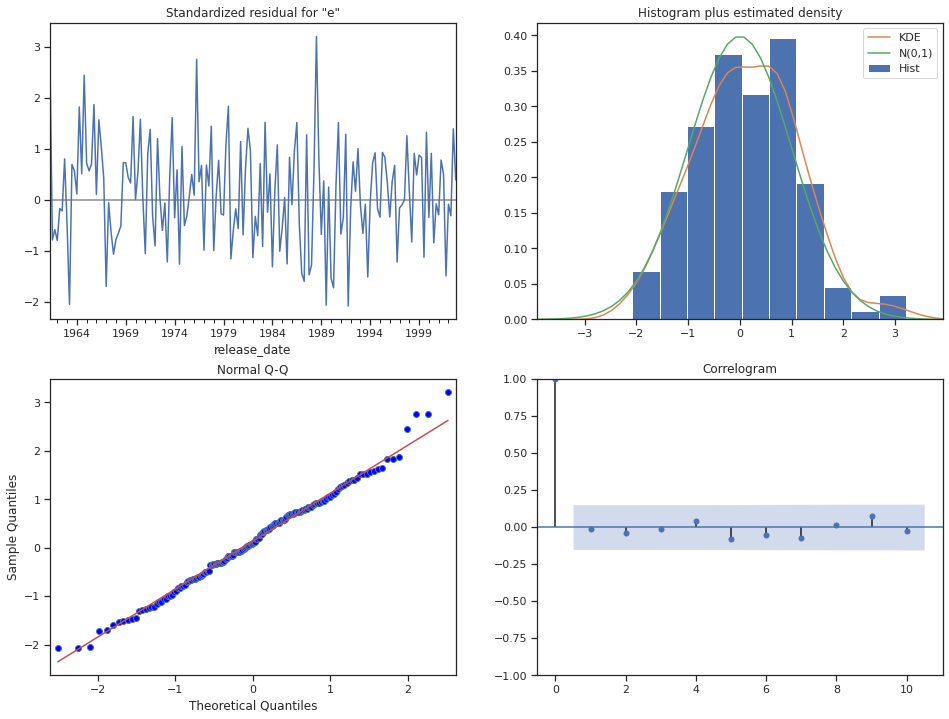

In [29]:
arima_energy_results.plot_diagnostics(figsize=(16, 12));

### Pronóstico con el modelo

*Pronosticar con el modelo seleccionado para cada serie para una ventana*

In [31]:
# Pronóstico con modelo entrenado con trainind data
# Crear objeto forecast
e_forecast = arima_energy_results.get_forecast(steps=72)   # 72 pasos hay en test

# Extraer el atributo predicted mean
e_meanForecast = e_forecast.predicted_mean
# otra forma de tener e_meanForecast:
# e_predictions = arima_energy_results.predict(start=spotify_test['energy'].index[0], end=spotify_test['energy'].index[-1])
e_residuals = spotify_test['energy'] - e_meanForecast

# Calcular los intervalos de confianza
e_conf_int = e_forecast.conf_int()

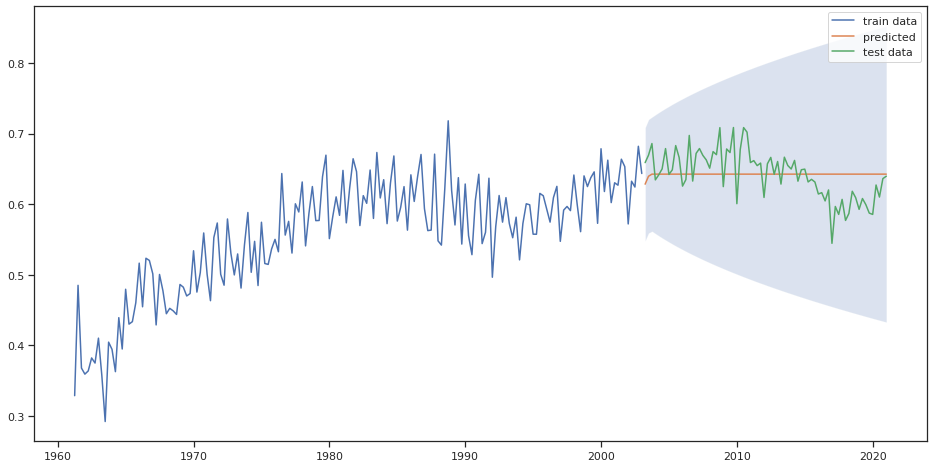

In [32]:
# Graficar datos de entrenamiento, test, y pronóstico
# Plot past
plt.figure(figsize=(16, 8))
plt.plot(spotify_train.index, spotify_train['energy'], label='train data');

# Graficar la predicción como una línea
plt.plot(dates_test, e_meanForecast, label='predicted');
plt.plot(spotify_test['energy'], label='test data')

# Sombra en los intervalos de confianza
plt.fill_between(dates_test, e_conf_int['lower energy'], e_conf_int['upper energy'], alpha=0.2);

# Plot legend and show figure
plt.legend();

In [33]:
# Estamos 4% lejos del promedio
print('Mean Absolute Percent Error:', round(np.mean(abs(e_residuals/spotify_test['energy'])),4))

Mean Absolute Percent Error: 0.0443


In [34]:
# 0.03 unidades de escala fuera en promedio
print('Root Mean Squared Error:', np.sqrt(np.mean(e_residuals**2)))

Root Mean Squared Error: 0.0343502592400202


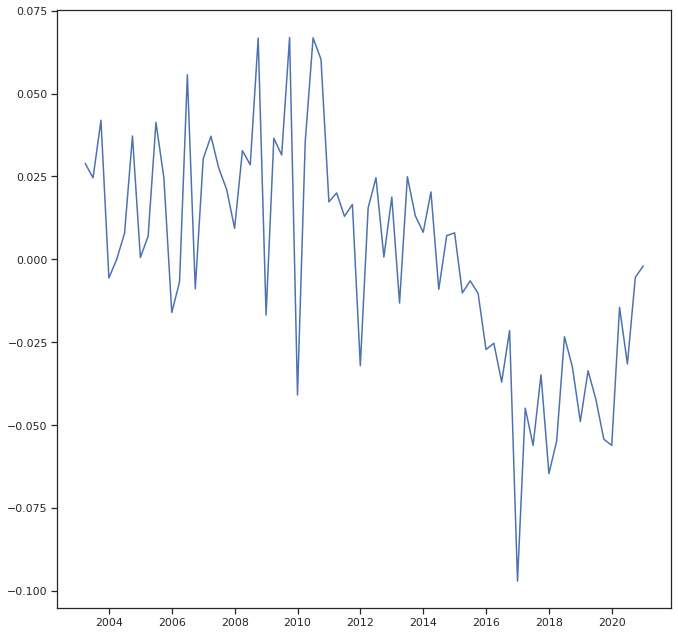

In [ ]:
# si hay un pattern en los residuos hay un conmportamiento dinámicno que no se está capturando.
# típicamente se vería como una onda, o como que decrece (un comportamiento lineal)
# creo que en mi caso se ve bastante bien los residuos. Erráticos
plt.plot(e_residuals);

**Rolling Forecast Origin**

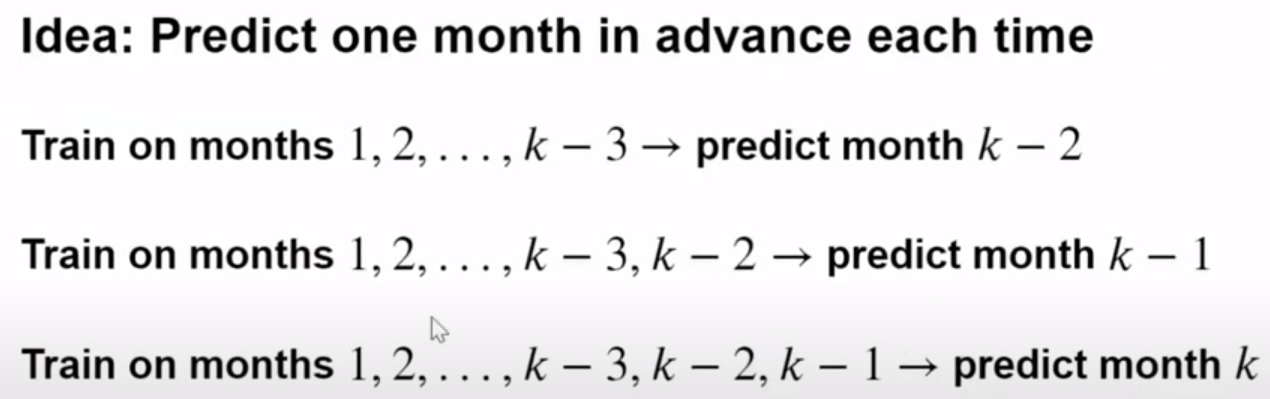


Predice solo un trimestre a la vez

In [ ]:
# create the model
predictions_rolling = pd.Series()
for end_date in spotify_test['energy'].index:
    train_data = spotify['energy'][pd.to_datetime('1961-03-31'):][:end_date - timedelta(days=1)]
    model = SARIMAX(train_data, order=(4, 1, 4))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]


In [ ]:
residuals_rolling = spotify_test['energy'] - predictions_rolling

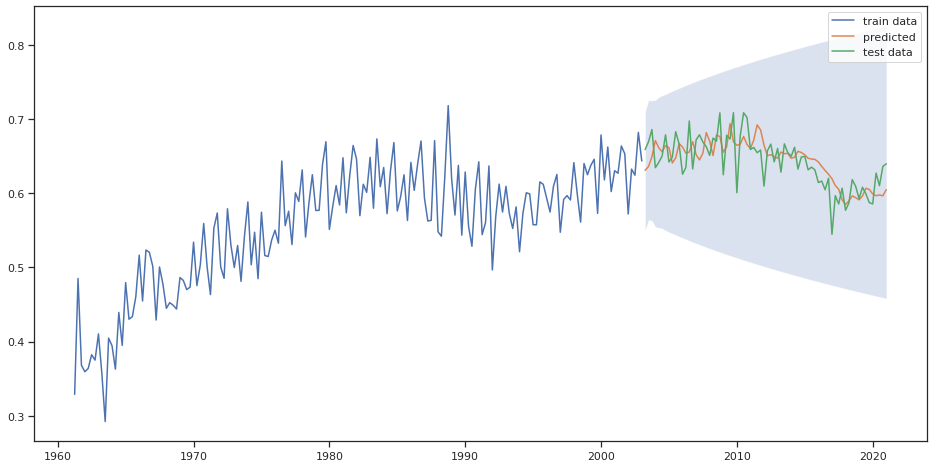

In [ ]:
# Graficar datos de entrenamiento, test, con rolling forecast
# Plot past
plt.figure(figsize=(16, 8))
plt.plot(spotify_train.index, spotify_train['energy'], label='train data');

# Graficar la predicción como una línea
plt.plot(dates_test, predictions_rolling, label='predicted');
plt.plot(spotify_test['energy'], label='test data')

# Sombra en los intervalos de confianza
plt.fill_between(dates_test, e_conf_int['lower energy'], e_conf_int['upper energy'], alpha=0.2);

# Plot legend and show figure
plt.legend();

la contra de esto es que cada periodo tengo que volver a entrenar el modelo. Tipicamente es OK en serie temporales.

In [ ]:
# Bajó un 1% lejos del promedio
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals_rolling/spotify_test['energy'])),4))

# 0.02 unidades de escala fuera en promedio
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_rolling**2)))

Mean Absolute Percent Error: 0.0329
Root Mean Squared Error: 0.025623177096586347


**Si queremos hacer predicciones en otra ventana de tiempo**

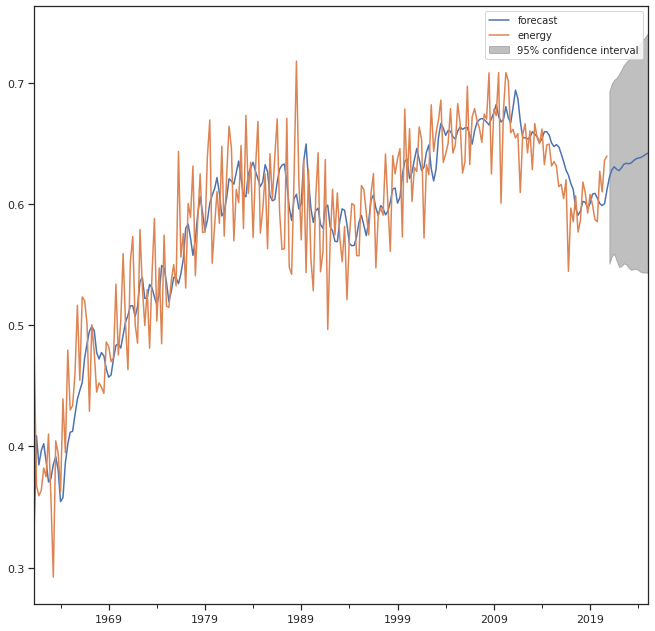

In [ ]:
e_mod_arima = ARIMA(spotify['energy'], order=(4, 1, 4))
e_res_arima = e_mod_arima.fit()
e_res_arima.plot_predict(start='1961', end='2025');
plt.legend(fontsize=10);

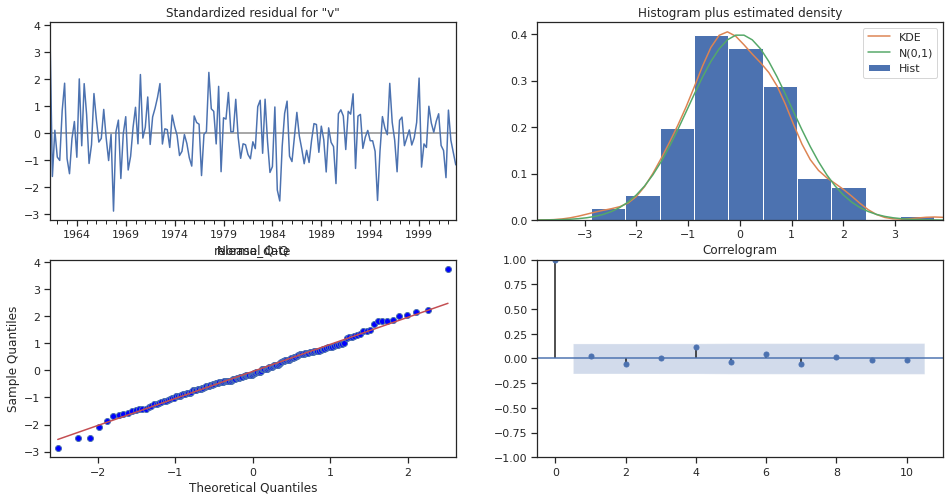

In [ ]:
arima_valence_results.plot_diagnostics(figsize=(16,12));

## Modelado ➡ variable Valence 😄

### Estimando el orden del modelo

In [ ]:
# Estimando el mejor modelo ARIMA para valence
order_valence =[]
# Loop sobre orden de AR
for p in range(4):
    # Loop sobre orden de Integración
    for d in range(2):
        # Loop sobre orden de MA
        for q in range (2):
            try:
                # Ajuste del modelo modelo
                model = SARIMAX(spotify_train['valence'], order=(p,d,q))
                results = model.fit()
                # impresión del orden del modelo con valores AIC/BIC
                #print(p, d, q, results.aic, results.bic)
                # Sumar orden y resultados a la lista
                order_valence.append((p, d, q, results.aic, results.bic))
            except:
                # Impresión de AIC y BIC como None cuando el modelo falla
                print(p, d, q, None, None)
 
# Creación de dataframe con los órdenes del modelo y los resultados de AIC/BIC
order_df_valence = pd.DataFrame(order_valence, columns=['p', 'd', 'q', 'aic', 'bic'])

### Selección del Modelo

In [ ]:
v_autoarima = pm.auto_arima(spotify_train['valence'], seasonal=True)
v_autoarima

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
order_df_valence.sort_values('bic').head(5)

,p,d,q,aic,bic
7,1,1,1,-667.833118,-658.479136
3,0,1,1,-664.181690,-657.945702
11,2,1,1,-665.988986,-653.517011
5,1,0,1,-660.547549,-651.175657
9,2,0,1,-662.510735,-650.014879


In [ ]:
order_df_valence.sort_values('aic').head(5)

,p,d,q,aic,bic
7,1,1,1,-667.833118,-658.479136
11,2,1,1,-665.988986,-653.517011
15,3,1,1,-665.280921,-649.690952
3,0,1,1,-664.181690,-657.945702
9,2,0,1,-662.510735,-650.014879


In [ ]:
# Modelo ARIMA para valence
arima_valence = SARIMAX(spotify_train['valence'], order=(1,1,1))
arima_valence_results = arima_valence.fit()
print(arima_valence_results.summary())

                               SARIMAX Results                                
Dep. Variable:                valence   No. Observations:                  168
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 336.917
Date:                Fri, 30 Jul 2021   AIC                           -667.833
Time:                        14:15:10   BIC                           -658.479
Sample:                    03-31-1961   HQIC                          -664.037
                         - 12-31-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2153      0.087     -2.463      0.014      -0.387      -0.044
ma.L1         -0.8330      0.061    -13.668      0.000      -0.952      -0.714
sigma2         0.0010   9.98e-05     10.274      0.0

### Análisis de Diagnóstico

### Pronósticos con el modelo

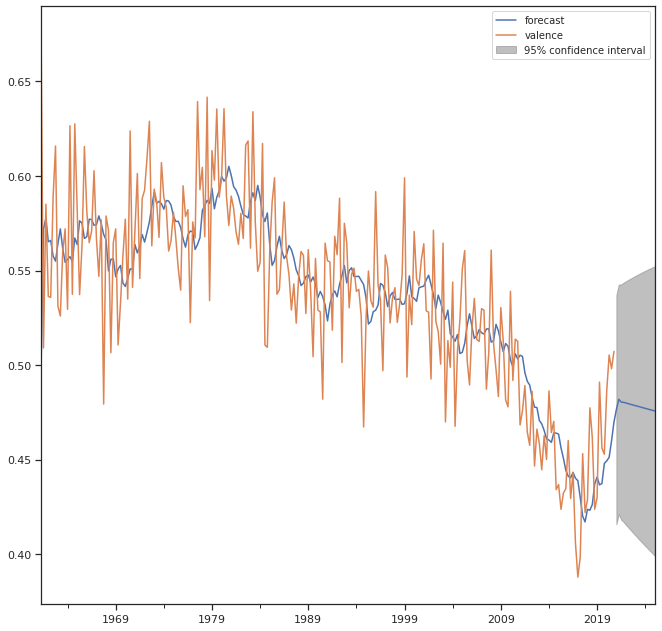

In [ ]:
v_mod_arima = ARIMA(spotify['valence'], order=(1, 1, 1))
v_res_arima = v_mod_arima.fit()
v_res_arima.plot_predict(start='1961', end='2025');
plt.legend(fontsize=10);

# Análisis de Resultados

# Conclusiones